# Recommender Systems

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
from IPython.display import display

from sklearn.decomposition import NMF

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

## Dummy Dataset

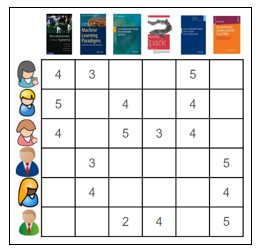

Before we apply our algorithm to a real dataset, we first reconstruct the dataset from the slides.

In [ ]:
deals = pd.read_csv("deals_dummy.csv")
deals.head()

In [ ]:
categories = pd.read_csv("categories_dummy.csv")
categories

## Create base class
There does not exist any recommender systems in Scikit-Learn. Therefore we create our own base-class with the usual `fit`, `predict` and `evaluate` methods.

In [ ]:
class RecommenderSystem:
    def fit(self, deals: pd.DataFrame, categories: pd.DataFrame):
        pass
    
    def predict(self, deals: pd.DataFrame, n_recommendations: int, n_neighbors: int) -> pd.DataFrame:
        pass
    
    def recommend(self, user_to_item_vector: pd.Series, n_recommendations: int, n_neighbors: int):
        pass

## Random Recommender

Before we start implementing our recommender algorithms, we implement a baseline recommender which randomly recommends a product.

In [ ]:
class RandomRecommender(RecommenderSystem):
    def fit(self, deals: pd.DataFrame, categories):
        self.categories = categories
    
    def predict(self, deals: pd.DataFrame, n_recommendations: int, n_neighbors: int =-1) -> pd.DataFrame:
        recommendations = {}
        for user_id in sorted(deals.user_id.unique()):
            recommendations[user_id] = self.categories.sample(n_recommendations).name.values
        recommendations = pd.DataFrame(data=recommendations).T
        recommendations.index.name = "user_id"
        return recommendations

Let's try our recommender

In [ ]:
n_recommendations = 3

recommender = RandomRecommender()
recommender.fit(deals, categories)

recommender.predict(deals, n_recommendations)

## Top-N Recommender

Another common baseline algorithm is a Top-N recommender, that suggest the N categories with the highest rating.

In [ ]:
class TopNRecommender(RecommenderSystem):
    def fit(self, deals: pd.DataFrame, categories: pd.DataFrame):
        sum_categories = deals.groupby("category_id").sum().rating
        top_category_ids = sum_categories.argsort()[::-1].values
        self.top_categories = categories[categories.category_id.isin(top_category_ids)].name
    
    def predict(self, deals: pd.DataFrame, n_recommendations: int, n_neighbors: int =-1) -> pd.DataFrame:
        top_n_categories = self.top_categories[:n_recommendations]
        recommendations = {}
        for user_id in sorted(deals.user_id.unique()):
            recommendations[user_id] = top_n_categories
        recommendations = pd.DataFrame(data=recommendations).T
        recommendations.index.name = "user_id"
        return recommendations

Let's try our recommender

In [ ]:
n_recommendations = 3

recommender = TopNRecommender()
recommender.fit(deals, categories)

recommender.predict(deals, n_recommendations)

## Item-to-Item Collaborative Filtering
We start by implementing a Item-to-Item collaborative filtering recommender system.

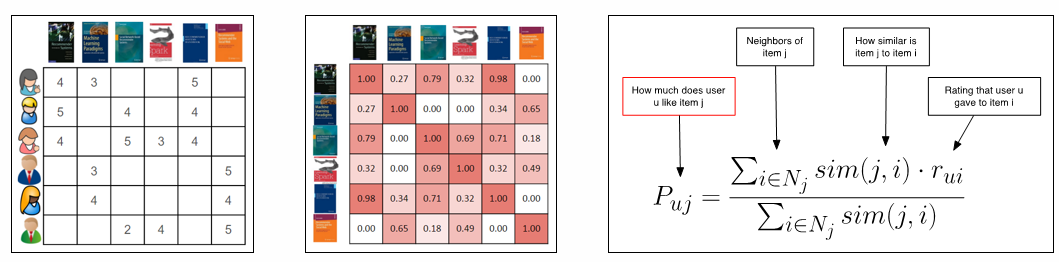

### Build User-to-Item Matrix
In order to implement our Item-to-Item Collaborative Filtering recommender, we need a User-to-Item-Matrix. Let's implement it in the base class.

In [ ]:
class RecommenderSystem(RecommenderSystem):
    def get_user_to_item_matrix(self, deals : pd.DataFrame, categories : pd.DataFrame) -> pd.DataFrame:
        # START YOUR CODE
        
        
        
        
        
        
        
        
        # END YOUR CODE
        return user_to_item_matrix

*Click on the dots to display the solution*

In [ ]:
class RecommenderSystem(RecommenderSystem):
    def get_user_to_item_matrix(self, deals : pd.DataFrame, categories : pd.DataFrame) -> pd.DataFrame:
        # To make sure that we have all categories in our deals, we add dummy deals for each category
        dummy_user_id = -1
        dummy_deals = [[dummy_user_id, category.category_id, 0] 
                       for category in categories.itertuples()]
        dummy_deals = pd.DataFrame(data=dummy_deals, columns=deals.columns)
        deals = deals.append(dummy_deals, ignore_index=True)

        deals = pd.merge(deals, categories, on='category_id', how="left")
        deals = deals.rename(columns={"name" : "category_name"})

        user_to_item_matrix = pd.pivot_table(
            deals, index=deals.user_id, columns="category_name", 
            values="rating", fill_value=0, aggfunc="sum")
        # remove dummy_deal column
        user_to_item_matrix = user_to_item_matrix[user_to_item_matrix.index != dummy_user_id]
        return user_to_item_matrix

Let's check if we get the same result as in the slides

In [ ]:
user_to_item_matrix = RecommenderSystem().get_user_to_item_matrix(deals, categories)
print(user_to_item_matrix.shape)
user_to_item_matrix

That looks similar.

### Build Item-to-Item weight matrix
Now we implement the Item-to-Item weight matrix. To do so, we need a similarity measure. We use the well known cosine similarity. We implement it in the base class.

> Implement the cosine similarity

In [ ]:
class RecommenderSystem(RecommenderSystem):
    def cosine_similarity(self, v1, v2):
        pass

*Click on the dots to display the solution*

In [ ]:
class RecommenderSystem(RecommenderSystem):
    def cosine_similarity(self, v1, v2):
        sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        return sim

> Implement the code for the Item-to-Item matrix.

In [ ]:
class ItemToItemRecommenderSystem(RecommenderSystem):
    def get_item_to_item_matrix(self, user_to_item_matrix):
        # START YOUR CODE
    
    
    
        # END YOUR CODE
    
        item_to_item_matrix = item_to_item_matrix.fillna(0)

        return item_to_item_matrix

*Click on the dots to display the solution*

In [ ]:
class ItemToItemRecommenderSystem(RecommenderSystem):
    def get_item_to_item_matrix(self, user_to_item_matrix):
        item_to_item_matrix = [[self.cosine_similarity(p1, p2) 
                      for p1 in user_to_item_matrix.T.values] 
                        for p2 in user_to_item_matrix.T.values]

        item_to_item_matrix = pd.DataFrame(data=item_to_item_matrix,
                                          columns=user_to_item_matrix.columns.values,
                                          index=user_to_item_matrix.columns.values)
        item_to_item_matrix = item_to_item_matrix.fillna(0)

        return item_to_item_matrix

Let's check if we get the same results as in the slides

In [ ]:
item_to_item_matrix = ItemToItemRecommenderSystem().get_item_to_item_matrix(user_to_item_matrix)

print(item_to_item_matrix.shape)
display(item_to_item_matrix.head())
sns.heatmap(item_to_item_matrix.iloc[0:10, 0:10], annot=True, cmap='RdYlGn_r', linewidths=0.5, fmt='.2f')

### Implement the `fit ` function

> Store the categories and calculate the user to item and the item to item matrices

In [ ]:
class ItemToItemRecommenderSystem(ItemToItemRecommenderSystem):
    def fit(self, deals: pd.DataFrame, categories: pd.DataFrame):
        # START YOUR CODE
        
        
        # END YOUR CODE
        pass

*Click on the dots to display the solution*

In [ ]:
class ItemToItemRecommenderSystem(ItemToItemRecommenderSystem):
    def fit(self, deals: pd.DataFrame, categories: pd.DataFrame):
        self.categories = categories
        user_to_item_matrix = self.get_user_to_item_matrix(deals, categories)
        self.item_to_item_matrix = self.get_item_to_item_matrix(user_to_item_matrix)

### Implement the `recommend` function
Now we're ready to finally implement the `recommend` function.

> Complete the `recommend` function

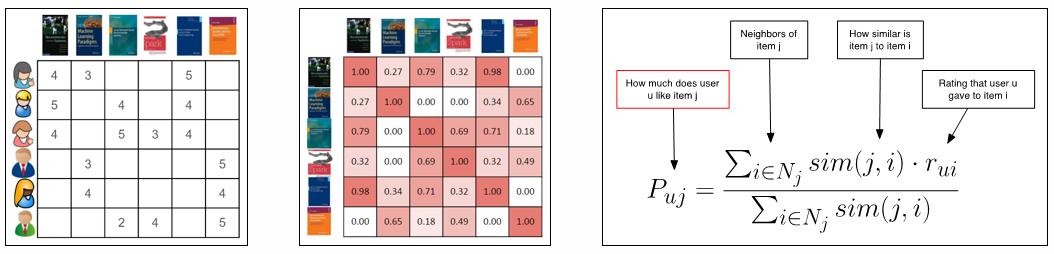

In [ ]:
class ItemToItemRecommenderSystem(ItemToItemRecommenderSystem):   
    def recommend(self, user_to_item_vector: pd.Series, n_recommendations: int, n_neighbors: int):
        predictions = []
        for i, view in enumerate(user_to_item_vector):
            if view != 0:
                predictions.append(-1)
                # we are only interested in categories without ratings.
                continue
            
            # filter for items that have at least one view
            idx = np.where(user_to_item_vector > 0)
            rating = user_to_item_vector.values[idx]
            similarities = self.item_to_item_matrix.values[i][idx]
            
            # neighborhood search
            idx_most_similar = similarities.argsort()[::-1][0:n_neighbors]
            rating = rating[idx_most_similar]
            similarities = similarities[idx_most_similar]
            
            
            # START YOUR CODE
            # Calculate the predictions according to the formula
            # prediction = ...
            
            
            # END YOUR CODE
            
            predictions.append(prediction)
        
        predictions = np.array(predictions)
        idx_best_recommendations = predictions.argsort()[::-1][:n_recommendations]
        rec_categories = user_to_item_vector.iloc[idx_best_recommendations].index
        
        best_predictions = predictions[idx_best_recommendations]
        return list(zip(rec_categories, best_predictions))

*Click on the dots to display the solution*

In [ ]:
class ItemToItemRecommenderSystem(ItemToItemRecommenderSystem):   
    def recommend(self, user_to_item_vector: pd.Series, n_recommendations: int, n_neighbors: int):
        predictions = []
        for i, view in enumerate(user_to_item_vector):
            if view != 0:
                predictions.append(-1)
                # we are only interested in categories without ratings.
                continue
            
            # filter for items that have at least one view
            idx = np.where(user_to_item_vector > 0)
            rating = user_to_item_vector.values[idx]
            similarities = self.item_to_item_matrix.values[i][idx]
            
            # neighborhood search
            idx_most_similar = similarities.argsort()[::-1][0:n_neighbors]
            rating = rating[idx_most_similar]
            similarities = similarities[idx_most_similar]

            prediction = np.dot(similarities, rating) / np.sum(similarities) \
                if np.sum(similarities) != 0 else 0
            predictions.append(prediction)
        
        predictions = np.array(predictions)
        idx_best_recommendations = predictions.argsort()[::-1][:n_recommendations]
        rec_categories = user_to_item_vector.iloc[idx_best_recommendations].index
        
        best_predictions = predictions[idx_best_recommendations]
        return list(zip(rec_categories, best_predictions))

Okay, let's test the code. We use 2 neighbors for now.



#### Calculate recommendations by hand
To do so, we calculate some examples by hand and check if our recommender gets the same result.

Rating that user 1 would give to book C

In [ ]:
(0.71 * 5 + 0.79 * 4)/(0.71 + 0.79)

Rating that user 1 would give to book D

In [ ]:
(0.32 * 5 + 0.32 * 4) / (0.32 + 0.32)

Rating that user 1 would give to book F

In [ ]:
(0.65 * 3)/0.65

#### Use our recommend function

In [ ]:
user_to_item_vector = user_to_item_matrix.iloc[0]
user_to_item_vector

In [ ]:
recommender = ItemToItemRecommenderSystem()
recommender.fit(deals, categories)

recommender.recommend(user_to_item_vector, n_recommendations=3, n_neighbors=2)

### Implement the `predict` function

We want a function that calls the `recommend` function for all users and returns the predictions in the same format as our previously implemented random recommender.

In [ ]:
class ItemToItemRecommenderSystem(ItemToItemRecommenderSystem):   
    def predict(self, deals: pd.DataFrame, n_recommendations: int, n_neighbors: int) -> pd.DataFrame:
        user_to_item_matrix = self.get_user_to_item_matrix(deals, self.categories)
        
        all_recommendations = {}
        for user_id in tqdm(user_to_item_matrix.index):
            user_to_item_vector = user_to_item_matrix[user_to_item_matrix.index == user_id].iloc[0]
            recommendations = self.recommend(user_to_item_vector, n_recommendations, n_neighbors)
            recommendations = [rec[0] for rec in recommendations]
            all_recommendations[user_id] = recommendations

        all_recommendations = pd.DataFrame(data=all_recommendations).T
        all_recommendations.index = user_to_item_matrix.index
        return all_recommendations

In [ ]:
recommender = ItemToItemRecommenderSystem()
recommender.fit(deals, categories)

recommender.predict(deals, n_recommendations=3, n_neighbors=2)

Great, we have now implemented our Item-to-Item Collaborative Filtering recommender!

## Implement evaluation pipeline

To measure the performance of our recommender, we implement a function that calculates the min precision@k metric. Note that the evaluation is completely different to what we have seen in the previous lectures. We use our training set to recommend categories and then check if they occur in the test set.

The min precision@k metric can be implemented as follows

In [ ]:
def min_precision_at_k(k, deals, recommendations):
    if len(deals) == 0:
        # this case should not happen!
        return 0
    return len(set(deals) & set(recommendations)) / min(k, len(deals))

We now use the min precision@k metric to implement our evaluation pipeline.

In [ ]:
def evaluate(recommender, train: pd.DataFrame, test: pd.DataFrame, categories, n_recommendations:int, n_neighbors=-1, verbose=False) -> pd.DataFrame:
    recommendations = recommender.predict(train, n_recommendations, n_neighbors)
        
    precisions = []
    for user_id in test.user_id.unique():
        if not user_id in train.user_id:
            # User is not contained in training set
            continue
        rec_categories = recommendations[recommendations.index==user_id].values
        if not len(rec_categories) > 0:
            # nothing could be recommended
            continue
        actual_categories = test[test.user_id==user_id].merge(categories, how="left", on="category_id").name.values
        precision = min_precision_at_k(n_recommendations, actual_categories, rec_categories[0])
        if verbose:
            print("actual:", actual_categories, "recommendations:", rec_categories, "->", precision)
        precisions.append(precision)
        
    return np.mean(precisions) 

If we run the evaluation code on the dummy data, the result is of course zero, because we did not split the data into a training and test set. 

In [ ]:
recommender = ItemToItemRecommenderSystem()
recommender.fit(deals, categories)

evaluate(recommender, deals, deals, categories, n_recommendations=2, n_neighbors=2, verbose=True)

> Look at the code and try to understand why the precision is zero.

## STUCard Dataset

[STUcard](https://www.stucard.ch/) provided us a dump of their productive database. We are required to implement a collaborative recommender system that recommends a suitable deal based on the previous views.

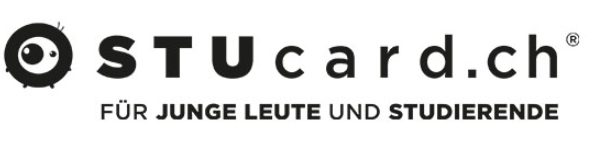

### Prepare Dataset
Our dataset consists of more than 200'000 entries where we can see the amount of times a user has viewed a specific category.

In [ ]:
deals = pd.read_csv("deals.csv")
print(deals.shape)
deals.head()

Let's plot the data

In [ ]:
categories_per_user = deals.groupby("user_id").agg({"category_id": "count"}).reset_index()
categories_per_user.columns = ["user", "#categories"]

users_per_category = deals.groupby("category_id").agg({"user_id": "count"}).reset_index()
users_per_category.columns = ["category", "#users"]

fig, ax = plt.subplots(2, 2, figsize=(10,10))  # 1 row, 2 columns

ax[0,0].hist(categories_per_user['#categories'], bins=np.linspace(0, 100, 50), alpha=0.75)
ax[0,0].set_title('Categories per User')
ax[0,1].boxplot(categories_per_user['#categories'])
ax[0,1].set_title('Categories per User')


ax[1,0].hist(users_per_category['#users'], bins=np.linspace(0, 8000, 40), alpha=0.75)
ax[1,0].set_title('Users per Category')
ax[1,1].boxplot(users_per_category['#users'])
ax[1,1].set_title('Users per Category')

The data looks a bit unbalanced. Let's have a look how our models perform with this dataset.

We rename the column *views* to *rating*.

In [ ]:
deals = deals.rename(columns={"views": "rating"})
deals.head()

In [ ]:
categories = pd.read_csv("categories.csv")
print(categories.shape)
categories.head()

#### Split Dataset

In [ ]:
train, test = train_test_split(deals, test_size=0.05, random_state=42)
print("train", train.shape)
print("test", test.shape)

test.head()

## Evaluate recommenders

Let's compare our implemented recommenders with the STUCard dataset. For our evaluation process we calculate 5 recommendations.

In [ ]:
n_recommendations = 5

### Evaluate our Random Recommender

In [ ]:
recommender = RandomRecommender()
recommender.fit(train, categories)

recommender.predict(test.iloc[0:10], n_recommendations)

In [ ]:
precision = evaluate(recommender, train, test, categories, n_recommendations)
precision

### Evaluate our Top-N Collaborative Filtering Recommender

In [ ]:
recommender = TopNRecommender()
recommender.fit(train, categories)

recommender.predict(test.iloc[0:10], n_recommendations)

### Evaluate our Item-to-Item Collaborative Filtering Recommender

In [ ]:
recommender = ItemToItemRecommenderSystem()
recommender.fit(train, categories)

recommender.predict(test.iloc[0:10], n_recommendations, n_neighbors=12)

It seems like our item-to-item recommender often recommends the same product...

Let's run the evaluation. Note: Running this cell may take some minutes

In [ ]:
precision = evaluate(recommender, train, test, categories, n_recommendations=5, n_neighbors=12)
precision

## Assignment
Now open the ILIAS quiz  and answer the questions.

> Given a user who is interested in *Computer*, *Bar* and *Hotels*. Fit the item-to-item collaborative filtering recommender system. What categories would you recommend? Calculate 3 recommendations and use 10 neighbors for the neighborhood search.

In [ ]:
user = pd.DataFrame(data={
    "user_id": [1, 1, 1],
    "category_id": categories[categories["name"].isin(["Computer", "Bar", "Hotels"])].category_id.values,
    "rating": [1, 1, 1]
})
user

## Remarks to the STUCard dataset

1. We have implemented a recommender system that works with explicit data such as ratings or likes.
1. The STUcard dataset does not contain any explicit data but only page views (implicit data)
1. If we would like to use our recommender system for implicit data, we would have to somehow transform our data. Have a look at the paper *Collaborative Filtering for Implicit Feedback Datasets* from Hu et al. (http://yifanhu.net/PUB/cf.pdf) to get an idea how we could do that.
1. Furthermore we did not perform any hyper parameter search. Maybe we could further improve our performance by optimizing the parameter `n_neighbors`...
1. FYI: The ABIZ research team was able to build a recommender algorithm that achieved a min precision@k of about 34% (with k=3) with the STUCard dataset.

That's it for the topic of recommender systems.